# Data calibration
In this notebook, we demonstrate the data calibration, which aligns the real world measurement data with the synthetic data.
This is done solely with information extracted from normal data, that is, data without any defect. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/data_calibration.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

SYN_DATA_PATH = Path(r"../data/synthetic/")
REAL_DATA_PATH = Path(r"../data/real_world/")

random_state = None

In [3]:
def init():
    IN_COLAB = 'google.colab' in sys.modules

    if(IN_COLAB):
        !git clone https://github.com/berni-lehner/structural_health_monitoring.git
        sys.path.insert(0,"/content/structural_health_monitoring/src")
        sys.path.insert(0,"/content/structural_health_monitoring/data")    
    else:
        sys.path.insert(0,"../src")
        sys.path.insert(0,"../data")

    try:
        from zippeekiyay import namelist
    except ImportError or ModuleNotFoundError:
        print('installing zippee-ki-yay...')
        !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

        from zippeekiyay import namelist

In [4]:
def init_data():
    from DataDownloader import DataDownloader as ddl
    
    url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"

    start_time = time.perf_counter()
    dl_succeed = ddl.download_and_unpack(url, SYN_DATA_PATH, cache=True)
    end_time = time.perf_counter()
    print(f"time passed: {end_time-start_time:.2f} s")
    print(f"downloading successful: {dl_succeed}")    

In [5]:
# initialize environment, paths, etc...
init()
#...and download raw data if not already downloaded
init_data()


from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)

from bench_utils import (
    classification_benchmark,
    get_aa_experiment,
    aabb_classification_benchmark,
    extract_metrics)

time passed: 5.36 s
downloading successful: True


In [6]:
from DataDownloader import DataDownloader as ddl
from manifold_utils import tsne_embedding
from LogFilterbank import LogFilterbank
from plot_utils import plot_embedding_targets, init_plotting
from plot_utils import plot_classwise_dist, plot_classwise_kde
from feature_utils import extract_dctc

# configure fonts, etc...
init_plotting()

In [7]:
from data_utils import load_raw_specs, FEATURE_LIST, REAL_FEATURE_LIST

In [8]:
file_names = list(SYN_DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(SYN_DATA_PATH, 'raw_specs.pkl')

In [9]:
%%time

df_syn = load_raw_specs(file_names=file_names, cache_file=pickle_name)

df_syn.head()

CPU times: total: 328 ms
Wall time: 304 ms


,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,spec_793,spec_794,spec_795,spec_796,spec_797,spec_798,spec_799,spec_800,y_radius,file
0,169595.281250,8587.643555,4405.353516,2962.550049,2231.654053,1790.029663,1494.315063,1282.449951,1123.198730,999.125977,...,20.244194,19.701979,19.418816,19.268551,19.157080,19.033304,18.895138,18.777649,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
1,175463.203125,8884.772461,4557.776855,3065.052979,2308.868164,1851.963745,1546.017578,1326.821899,1162.060669,1033.694946,...,20.653839,20.109507,19.824465,19.672564,19.559637,19.434490,19.294926,19.175934,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
2,191127.000000,9677.925781,4964.654297,3338.673340,2514.983154,2017.290161,1684.031616,1445.268066,1265.798218,1125.972900,...,21.747200,21.197222,20.907173,20.750906,20.634098,20.505287,20.361990,20.238989,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
3,224265.859375,11355.948242,5825.458496,3917.553955,2951.046875,2367.060303,1976.019043,1695.856812,1485.268921,1321.199219,...,24.059652,23.497778,23.197157,23.031666,22.906658,22.770107,22.618921,22.487450,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
4,202014.671875,10229.235352,5247.469238,3528.862793,2658.250488,2132.206055,1779.963257,1527.598267,1337.904663,1190.113892,...,22.507053,21.953161,21.659634,21.500336,21.380833,21.249477,21.103586,20.977800,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...


## keep only the defect radius as target variable

In [10]:
target_col = 'y_radius'

df_syn = df_syn.drop(columns='file')

df_syn = df_syn.sort_values(by=target_col) # make sure the class labels are sorted for further convenience

# load real world data

In [11]:
file_names = list(REAL_DATA_PATH.glob('**/*.csv'))

# DON'T use cached file, as it might be already calibrated!
pickle_name = None

In [12]:
%%time

df_real = load_raw_specs(file_names=file_names, cache_file=pickle_name,
                         synthetic=False)

df_real = df_real.drop(columns='file')

df_real.head()

CPU times: total: 3.84 s
Wall time: 3.85 s


,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,spec_792,spec_793,spec_794,spec_795,spec_796,spec_797,spec_798,spec_799,spec_800,y_radius
0,209748.09375,9652.499023,4838.913086,3270.454102,2478.553955,1993.630981,1670.339966,1434.609985,1252.947021,1116.836060,...,70.145370,67.905739,65.164368,62.730480,61.391220,60.383530,59.045780,57.848961,57.475739,0.5
1,186010.50000,9384.462891,4792.977051,3192.548096,2402.089111,1936.654053,1611.911987,1395.994995,1219.203003,1086.051025,...,66.292717,64.154602,61.130341,58.486542,56.930630,56.142281,55.281158,54.334419,53.891891,0.0
2,187751.40625,9330.993164,4870.725098,3283.666992,2470.452881,1985.991943,1658.965942,1432.484985,1256.777954,1117.840942,...,68.815804,65.497849,62.400700,59.613430,57.800491,56.901501,56.187489,55.756920,55.815151,1.5
3,202254.59375,9510.974609,4944.141113,3300.305908,2484.347900,1995.732056,1662.254028,1430.634033,1258.281006,1119.896973,...,72.835068,70.889969,69.263359,67.932709,67.124680,66.487930,66.249107,66.898750,68.204811,10.0
4,199351.90625,9830.353516,4995.249023,3349.498047,2506.902100,2019.145996,1693.484985,1446.027954,1270.186035,1132.603027,...,70.624588,67.462914,65.205872,63.518070,62.444839,61.863548,61.875359,62.392502,63.479961,12.0


In [13]:
feature_cols = df_syn.columns[0:-1]

### Sanity checking Data

In [14]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Columns: 802 entries, spec_0 to y_radius
dtypes: float32(802)
memory usage: 761.4 KB


In [15]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34152 entries, 0 to 34151
Columns: 802 entries, spec_0 to y_radius
dtypes: float32(802)
memory usage: 104.7 MB


In [16]:
assert np.sum(df_syn.columns==df_real.columns) == len(df_real.columns)

## Visualize Differences between Synthetic and Real World Data

In [17]:
ctr = Counter(df_syn[target_col])

Text(0.5, 1.0, 'Synthetic Data')

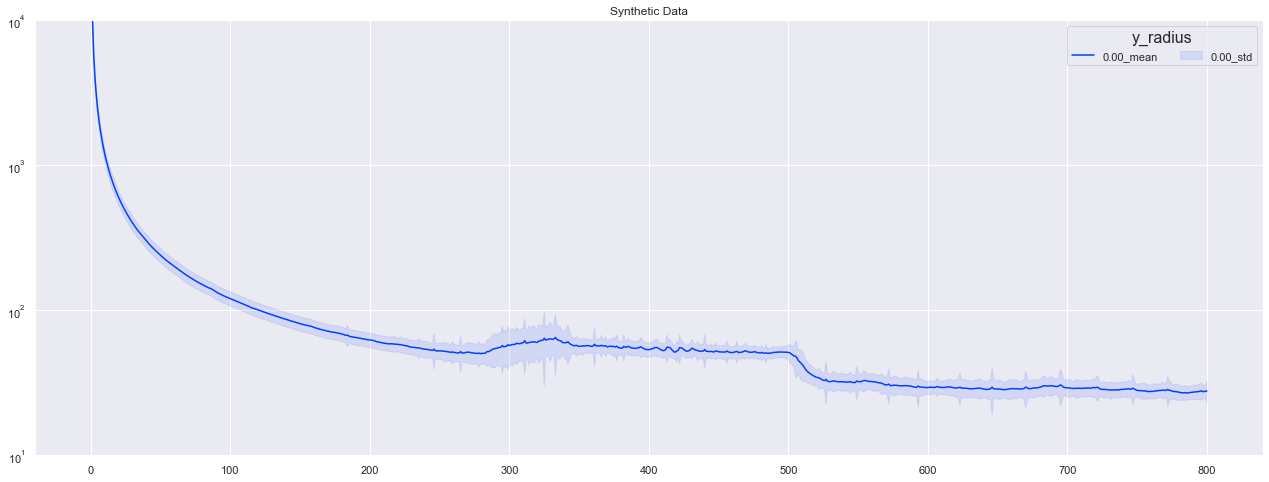

In [18]:
target_idx = 0

target = list(ctr.keys())[target_idx]

fig = plot_classwise_dist(df=df_syn[df_syn[target_col]==target])
fig.gca().legend(ncol=2, loc='best', title=target_col)
plt.yscale("log")
plt.ylim(10,10000)
plt.title("Synthetic Data")

Text(0.5, 1.0, 'Real World Data')

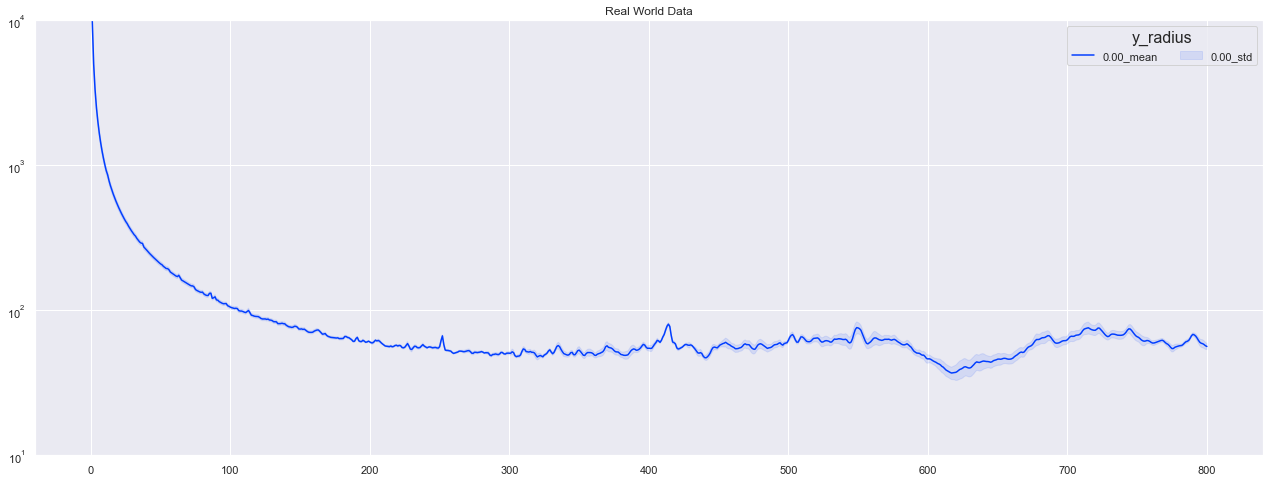

In [19]:
fig = plot_classwise_dist(df=df_real[df_real[target_col]==target])
fig.gca().legend(ncol=2, loc='best', title=target_col)
plt.yscale("log")
plt.ylim(10,10000)
plt.title("Real World Data")

## Compute Calibration
For now, we simply calibrate according to the mean values of the samples without any defect.

In [20]:
mean_spec_syn = df_syn.drop(columns=target_col)[df_syn[target_col]==target].mean(axis=0)
mean_spec_syn.shape

(801,)

In [21]:
mean_spec_real = df_real.drop(columns=target_col)[df_real[target_col]==target].mean(axis=0)
mean_spec_real.shape

(801,)

In [22]:
mean_spec_diff = mean_spec_syn-mean_spec_real
mean_spec_diff.shape

(801,)

## Visualize Calibration Result
As can be seen, the mean values of both real world and synthetic data are aligned after calibration.

Text(0.5, 1.0, 'Calibration Result')

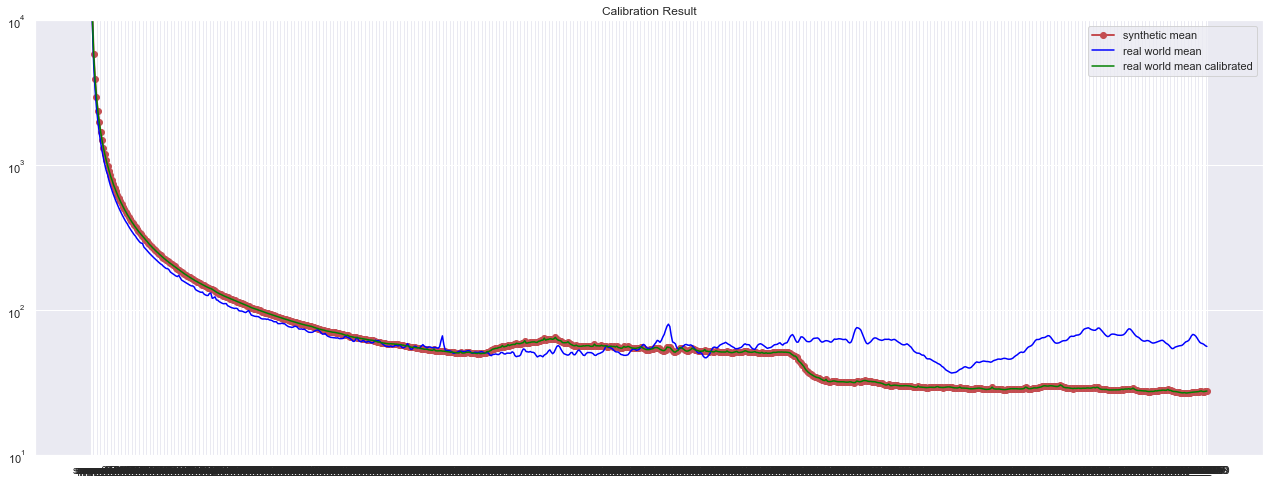

In [23]:
plt.plot(mean_spec_syn, 'ro-', label='synthetic mean', linewidth=2)
plt.plot(mean_spec_real, color='blue', label='real world mean')
plt.plot(mean_spec_real+mean_spec_diff, color='green', label='real world mean calibrated')
plt.yscale("log")
plt.ylim(10,10000)
plt.legend()
plt.title("Calibration Result")

## Store Calibration Data

In [24]:
mean_spec_diff.to_pickle(Path(REAL_DATA_PATH, "calibration.pkl"))

## A closer Look at the Calibration Results

### Apply Calibration

In [25]:
df_real_calib = df_real.iloc[:,0:-1].apply(lambda x: (x+mean_spec_diff), axis=1)
df_real_calib[target_col] = df_real[target_col]

### Keep only Normal Samples

In [26]:
df_syn_focus =  df_syn[df_syn[target_col]==0.0].copy()
df_real_focus =  df_real_calib[df_real_calib[target_col]==0.0].copy()

### Combine Synthetic and Real World Data

In [27]:
Xreal = df_real_focus.drop(columns=[target_col]).values
Xsyn = df_syn_focus.drop(columns=[target_col]).values

X = np.concatenate([Xreal, Xsyn], axis=0)
y = np.concatenate([np.repeat('real', len(Xreal)), np.repeat('synthetic', len(Xsyn))])

In [28]:
target_col = "origin"

df_X = pd.DataFrame(columns=feature_cols)
df_X[feature_cols] = X

df_y = pd.DataFrame(columns=[target_col])
df_y[target_col] = y

df = pd.concat([df_X, df_y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 802 entries, spec_0 to origin
dtypes: float32(801), object(1)
memory usage: 3.1+ MB


In [29]:
ctr = Counter(df[target_col])
ctr

Counter({'real': 9, 'synthetic': 990})

## Plot overview of feature value distributions according to target label
Due to the expected inaccuracy of the synthetic data in higher frequency ranges, we can observe a discrepancy in variance from the bin 500 and upwards.

(10, 10000)

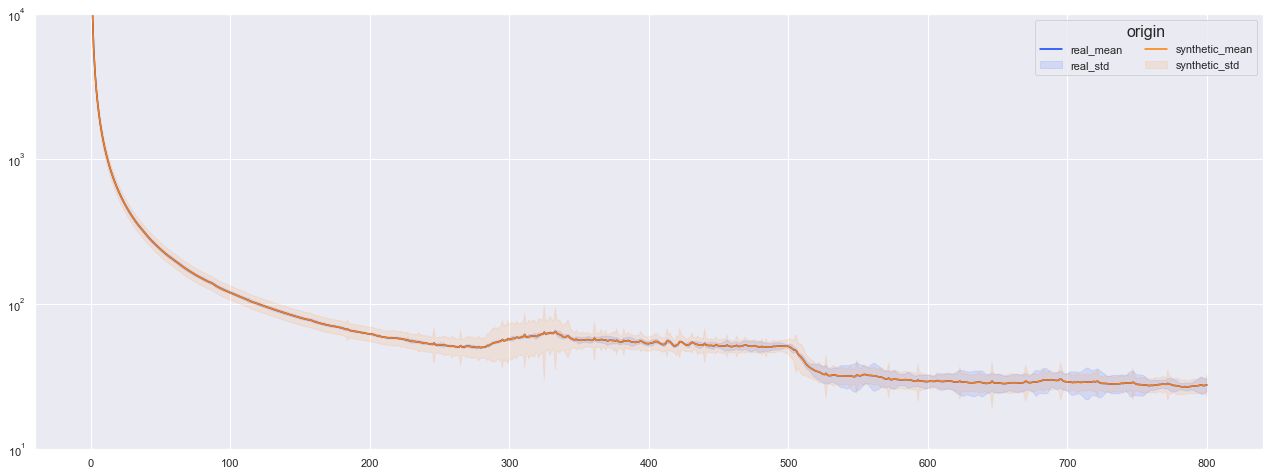

In [30]:
fig = plot_classwise_dist(df=df, label_col=target_col)
fig.gca().legend(ncol=2, loc='best', title=target_col)
plt.yscale("log")
plt.ylim(10,10000)

In [31]:
cntr = Counter(df[target_col])
labels = list(cntr.keys())
palette = sns.color_palette("bright", len(cntr.keys()))

In [32]:
feature_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(df.columns)-2,
    step=1,
    description='feature:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


focus_slider = widgets.IntSlider(
    value=-1,
    min=-1,
    max=len(cntr.keys())-1,
    step=1,
    description='target focus:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


def plot_feature_kde(df, label_col, labels, palette=None, feature_idx=0, focus=-1):
    fig = plot_classwise_kde(df=df, label_col=label_col, labels=labels,
                             palette=palette, feature_idx=feature_idx,
                             focus=focus)
    fig.gca().legend(ncol=2, loc='best', title=label_col)
    
    
widgets.interact(plot_feature_kde,
                 df=widgets.fixed(df),
                 label_col=widgets.fixed(target_col),
                 labels=widgets.fixed(labels),
                 palette=widgets.fixed(palette),
                 feature_idx=feature_slider,
                 focus=focus_slider);

interactive(children=(IntSlider(value=0, description='feature:', layout=Layout(width='100%'), max=800), IntSli…